In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.impute import KNNImputer
from pandas_profiling import ProfileReport

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [2]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

## Make a copy of your original dataset

why?

In [ ]:
# CODE HERE

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

## Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

In [3]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

In [4]:
# check dataset data types again
df.dtypes

age                   int64
income              float64
frq                   int64
rcn                   int64
mnt                   int64
clothes               int64
kitchen               int64
small_appliances      int64
toys                  int64
house_keeping         int64
dependents          float64
per_net_purchase      int64
gender               object
education            object
status               object
description          object
dtype: object

In [5]:
# check descriptive statistics again
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,8998.0,NaN,NaN,NaN,1966.05968,17.296552,1936.0,1951.0,1966.0,1981.0,1996.0
income,8952.0,NaN,NaN,NaN,69963.550827,27591.556226,10000.0,47741.0,70030.5,92218.0,140628.0
frq,8998.0,NaN,NaN,NaN,19.848077,10.903435,3.0,10.0,17.0,28.0,59.0
rcn,8998.0,NaN,NaN,NaN,62.469771,69.761802,0.0,26.0,53.0,79.0,549.0
mnt,8998.0,NaN,NaN,NaN,622.162814,646.768205,6.0,63.0,383.0,1076.0,3052.0
clothes,8998.0,NaN,NaN,NaN,50.446655,23.422249,1.0,33.0,51.0,69.0,99.0
kitchen,8998.0,NaN,NaN,NaN,7.039675,7.848139,0.0,2.0,4.0,10.0,75.0
small_appliances,8998.0,NaN,NaN,NaN,28.524116,12.586437,1.0,19.0,28.0,37.0,74.0
toys,8998.0,NaN,NaN,NaN,7.036897,7.924422,0.0,2.0,4.0,10.0,62.0
house_keeping,8998.0,NaN,NaN,NaN,6.929984,7.882655,0.0,2.0,4.0,9.0,77.0


In [7]:
#Define metric and non-metric features. Why?
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

## Fill missing values (Data imputation)

How can we fill missing values?

In [8]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [9]:
# count of missing values
df_central.isna().sum()

age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [15]:
df_central[metric_features].median()

age                  1966.0
income              70030.5
frq                    17.0
rcn                    53.0
mnt                   383.0
clothes                51.0
kitchen                 4.0
small_appliances       28.0
toys                    4.0
house_keeping           4.0
per_net_purchase       45.0
dtype: float64

In [18]:
# Check each step of these commands
modes = df_central[non_metric_features].mode().loc[0]
modes

education      Graduation
status            Married
gender                  M
dependents            1.0
description      OK nice!
Name: 0, dtype: object

In [24]:
# Fill NaNs on df_central
# CODE HERE

# fill missing vals in cat variables with mode
# fill missing vals in numeric features with median
fillna_values = pd.concat([df_central[metric_features].median(), modes])
df_central.fillna(fillna_values, inplace=True)
df_central

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
0,1946,90782.0,33,66,1402,37,5,44,10,3,0.0,19,M,Graduation,Together,Take my money!!
1,1936,113023.0,32,6,1537,55,1,38,4,2,0.0,9,F,PhD,Divorced,Take my money!!
2,1990,28344.0,11,69,44,32,19,24,1,24,1.0,59,M,Graduation,Married,Kind of OK
3,1955,93571.0,26,10,888,60,10,19,6,5,1.0,35,F,Master,Married,OK nice!
4,1955,91852.0,31,26,1138,59,5,28,4,4,1.0,34,F,Graduation,Together,Take my money!!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,1960,94367.0,28,1,896,68,5,21,3,4,1.0,55,F,1st Cycle,Single,Take my money!!
8994,1975,58121.0,12,6,61,53,6,28,7,6,1.0,71,M,2nd Cycle,Single,Meh...
8995,1986,54292.0,29,72,1011,41,11,36,1,11,0.0,31,M,Graduation,Together,Take my money!!
8996,1938,125962.0,38,75,1668,61,2,25,5,6,1.0,45,M,2nd Cycle,Married,Take my money!!


In [25]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [26]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
3,1955,93571.0,26,10,888,60,10,19,6,5,1.0,35,F,Master,NaN,OK nice!
61,1968,NaN,14,90,184,95,1,3,1,0,1.0,59,F,2nd Cycle,Married,Meh...
67,1981,60457.0,9,73,63,37,2,51,6,3,NaN,57,M,PhD,Married,Meh...
70,1944,116259.0,28,35,1279,17,6,54,3,20,0.0,11,M,Graduation,NaN,OK nice!
73,1967,75274.0,16,67,263,88,3,6,1,2,NaN,66,M,Graduation,Single,Kind of OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,1959,NaN,20,71,716,67,5,25,3,1,0.0,27,M,Graduation,Married,Meh...
8942,1950,92746.0,34,98,1399,50,5,36,5,4,NaN,28,M,Master,Married,Take my money!!
8964,1978,44661.0,6,49,33,18,18,35,16,13,1.0,42,M,1st Cycle,NaN,OK nice!
8972,1976,NaN,17,9,254,70,1,28,1,1,1.0,59,M,Graduation,Divorced,Meh...


In [30]:
# KNNImputer - only works for numerical variables. Fill NaNs on df_neighbors
imputer = KNNImputer(n_neighbors=5, weights="uniform")
# CODE HERE
# imputer.fit  # used to train a classifier
# imputer.fit_transform(df_neighbors) -> cannot be ran when there is categorical data cuz neighbors cannot be found
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])
df_neighbors

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
0,1946.0,90782.0,33.0,66.0,1402.0,37.0,5.0,44.0,10.0,3.0,0.0,19.0,M,Graduation,Together,Take my money!!
1,1936.0,113023.0,32.0,6.0,1537.0,55.0,1.0,38.0,4.0,2.0,0.0,9.0,F,PhD,Divorced,Take my money!!
2,1990.0,28344.0,11.0,69.0,44.0,32.0,19.0,24.0,1.0,24.0,1.0,59.0,M,Graduation,Married,Kind of OK
3,1955.0,93571.0,26.0,10.0,888.0,60.0,10.0,19.0,6.0,5.0,1.0,35.0,F,Master,NaN,OK nice!
4,1955.0,91852.0,31.0,26.0,1138.0,59.0,5.0,28.0,4.0,4.0,1.0,34.0,F,Graduation,Together,Take my money!!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,1960.0,94367.0,28.0,1.0,896.0,68.0,5.0,21.0,3.0,4.0,1.0,55.0,F,1st Cycle,Single,Take my money!!
8994,1975.0,58121.0,12.0,6.0,61.0,53.0,6.0,28.0,7.0,6.0,1.0,71.0,M,2nd Cycle,Single,Meh...
8995,1986.0,54292.0,29.0,72.0,1011.0,41.0,11.0,36.0,1.0,11.0,0.0,31.0,M,Graduation,Together,Take my money!!
8996,1938.0,125962.0,38.0,75.0,1668.0,61.0,2.0,25.0,5.0,6.0,1.0,45.0,M,2nd Cycle,Married,Take my money!!


In [37]:
# prints rows containing missing values
# any() returns columns with missing values, any(1) returns rows with missing values (defining axis)
df_neighbors.isna().any(1) # missing values only for categorical features

# normally, when computing nearest neighbors data should be scaled first and outliers should be removed

0       False
1       False
2       False
3        True
4       False
        ...  
8993    False
8994    False
8995    False
8996    False
8997    False
Length: 8998, dtype: bool

In [41]:
# See rows with NaNs imputed
# CODE HERE
df.loc[df[metric_features].isna().any(1)]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description


In [39]:
# let's keep the central imputation
df = df_central.copy()

## An overview of our previous data exploration

You can also explore this dataset using the exported `pandas-profiling` report.



![](../figures/exp_analysis/categorical_variables_frequecies.png)

![](../figures/exp_analysis/numeric_variables_histograms.png)

![](../figures/exp_analysis/numeric_variables_boxplots.png)

![](../figures/exp_analysis/pairwise_relationship_of_numerical_variables.png)

![](../figures/exp_analysis/correlation_matrix.png)

## Outlier removal

Why do we need to remove outliers? Which methods can we use?


Let's start by "manually" filtering the dataset's outliers

In [51]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters = (
    (df['education'] != 'OldSchool')
    &
    (df['status'] != 'Whatever')
    &
    (df['house_keeping'] < 50)
    &
    (df['kitchen'] < 50)
    &
    (df['toys'] < 50)
    
)

# amount of observations False (to remove)
print((~filters).sum())

df_1 = df[filters]

79


In [54]:
# should aim to remove 5% or less of the dataset when clearing outliers
# extremely dependent on the dataset and the knowledge you have on it

print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9912


### Outlier removal using only the IQR method

Why should you use/not use this method?

In [71]:
# Compute the IQR
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

iqr = q3 - q1
iqr

age                    30.00
income              44236.75
frq                    18.00
rcn                    53.00
mnt                  1013.00
clothes                36.00
kitchen                 8.00
small_appliances       18.00
toys                    8.00
house_keeping           7.00
dependents              1.00
per_net_purchase       29.00
dtype: float64

In [76]:
# Compute upper and lower limit (lower_limit = Q1 -1.5*IQR | upper_limit = Q3 + 1.5*IQR)
lower_lim = q1 - 1.5*iqr
upper_lim = q3 + 1.5*iqr

filters = []
# filter observations in metric features within the IQR
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df[metric].between(llim, ulim, inclusive='both'))

df_2 = df[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

# if % of data removed is too high and we want to remove outliers based on IQR we can increase IQR
# however, this use of IQR is generally not recommended 
# unless we have a feature we know nothing about (so we do not introduce bias)

Percentage of data kept after removing outliers: 0.8242


In [77]:
# Get the manual filtering version
df = df_1.copy()

## Feature extraction

A reminder of our metadata:
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

In [ ]:
# Try to pull as many features as you can; You can always drop them later on
# You can start by converting the 'age' variable to the actual age
# You can also store the birth year in another feature

# CODE HERE

## Variable transform
You may change the values of observations for a give variable:

In [66]:
# Remember the 'rcn' variable had an odd behavior? 
# This is the time to fix that

df_1.loc[df_1['rcn'] > 105, 'rcn'] = 105

C:\Users\nbcme\anaconda3\envs\DM_environment\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


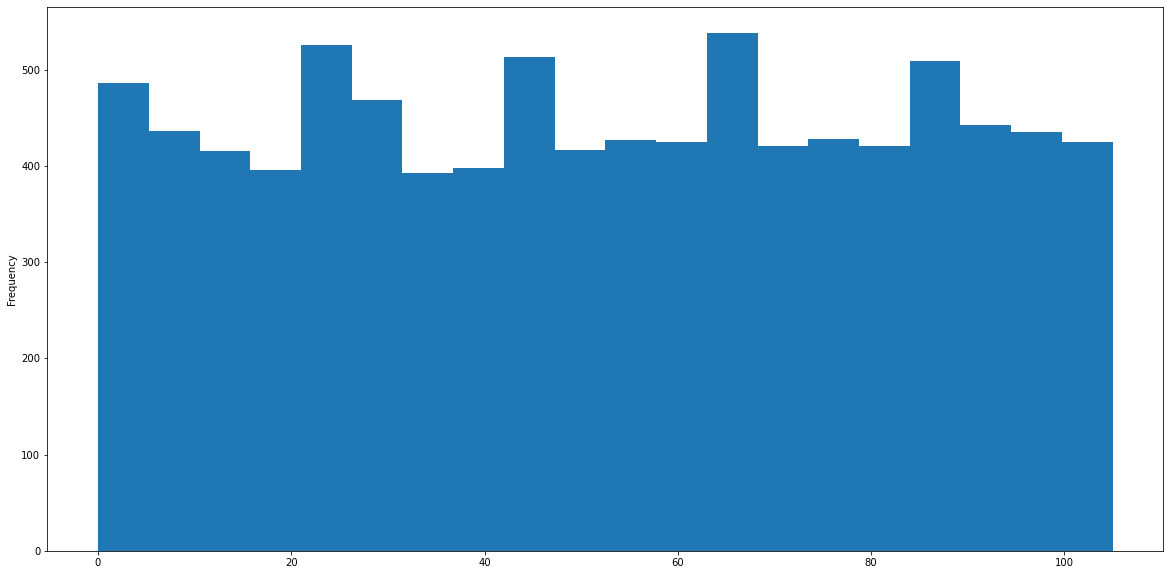

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

df_1['rcn'].plot.hist(figsize=(20,10), bins=20)
plt.show()

## Handling highly correlated variables

We already saw our original correlation matrix:
![](../figures/exp_analysis/correlation_matrix.png)

In [ ]:
# Select variables according to their correlations

# CODE HERE

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

In [ ]:
ProfileReport(
    df,
    title='Tugas Customer Data Preprocessed',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)